In [2]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: GoogleNet Inception V4
# Author: Tracy Tao
# Date: 2022/04/12
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

- Inception Block
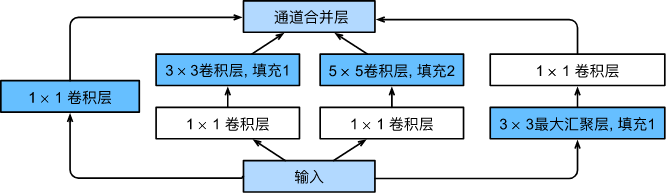
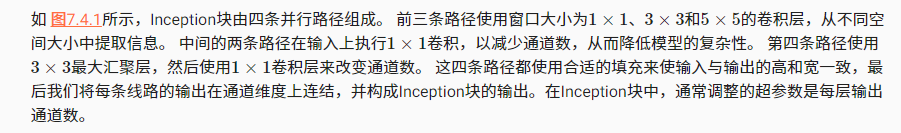

In [35]:
class Inception(nn.Module):
    '''Inception Block'''
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        '''如图四通道'''
        super(Inception, self).__init__(**kwargs)
        # channel 1: 1*1 Conv2d
        self.c1_1 = nn.Conv2d(in_channels, c1, kernel_size = 1)
        # channel 2 : 1*1 Conv2d + 3*3 Conv2d
        self.c2_1 = nn.Conv2d(in_channels, c2[0], kernel_size = 1)
        self.c2_2 = nn.Conv2d(c2[0], c2[1], kernel_size = 3, padding =1)
        # channel 3: 1*1 Conv2d + 5*5 Conv2d
        self.c3_1 = nn.Conv2d(c2[1], c3[0], kernel_size = 1)
        self.c3_2 = nn.Conv2d(c3[1], c3[1], kernel_size = 5, padding =2)
        # channel 4: 3*3 Maxpooling + 1*1 Conv2d
        self.c4_1 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding =1)
        self.c4_2 = nn.Conv2d(in_channels, c4, kernel_size =1)
    
    def forward(self, x):
        p1 = F.relu(self.c1_1(x))
        p2 = F.relu(self.c2_2(F.relu(self.c2_1)))
        p3 = F.relu(self.c3_2(F.relu(self.c3_1)))
        p4 = F.relu(self.c4_2(F.relu(self.c4_1)))
        # concat all channel outputs
        return torch.cat((p1, p2, p3, p4), dim=1)

- GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。
- **Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。**
- 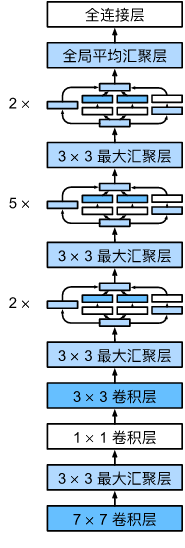

In [36]:
def block1():
    '''模块一： 7 * 7 Conv2d'''
    return nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3), nn.ReLU(),
                         nn.MaxPool2d(kernel_size = 3, stride = 2, padding =1))

In [37]:
def block2():
    '''模块二：1*1 Conv2d + 3*3 Conv2d + 3*3 Maxpooling'''
    return nn.Sequential(nn.Conv2d(64, 64, kernel_size =1), nn.ReLU(),
                         nn.Conv2d(64, 192, kernel_size =3, padding=1), nn.ReLU(),
                         nn.MaxPool2d(kernel_size = 3, stride =2, padding =1))

In [38]:
def block3():
    '''模块三： 2个Inception，继承block in：192'''
    return  nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                          Inception(256, 128, (128, 192), (32, 96), 64),
                          nn.MaxPool2d(kernel_size = 3, stride = 2, padding =1))

In [39]:
def block4():
    '''模块四：5个Inception, in_channel: 480'''
    return nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                         Inception(512, 160, (112, 224), (24, 64), 64),
                         Inception(512, 128, (128, 256), (24, 64), 64),
                         Inception(512, 112, (144, 288), (32, 64), 64),
                         Inception(528, 256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [40]:
def block5():
    '''模块五：5个Inception, in_channel: 832'''
    return nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                         Inception(832, 384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)),
                         nn.Flatten())

In [41]:
b1=block1()
b2=block2()
b3=block3()
b4=block4()
b5=block5()
net = nn.Sequential(b1,
                    b2,
                    b3,
                    b4,
                    b5,
                    nn.Linear(1024, 10))

Sequential
